<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/SVD%EB%A5%BC_MLP_NCF%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
!pip install datasets
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [25]:
# 데이터 로드

dataset = load_dataset("hscrown/Rating1000")
df = pd.DataFrame(dataset['train'])

# Swish 함수 사용


In [8]:
from tensorflow.keras.layers import Activation

# Swish 함수 정의
def swish(x):
    return x * tf.sigmoid(x)

# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation=swish)(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation=swish)(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation=swish)(mlp_layer)

# 출력층
mlp_output = Dense(1, activation='sigmoid')(mlp_layer)

# 반올림 함수 정의
def round_to_nearest_half(x):
    return round(x * 2) / 2

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 15)                15000     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 15)                24945     ['input_2[0][0]']             
                                                                                              

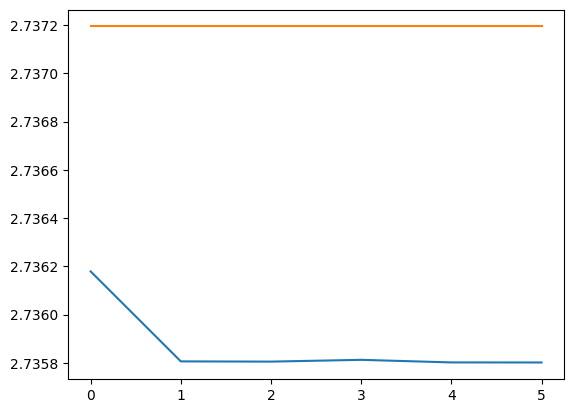

In [9]:
# 시각화
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])

# L2정규화 적용

시그모이드, swish함수가 오차값이 커서 relu함수로 돌아갓다.

In [14]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda

# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(mlp_layer)

# 출력층에 활성화 함수 적용 (Swish 함수)
def swish(x):
    return x * tf.keras.activations.sigmoid(x)

mlp_output = Dense(1, activation=swish)(mlp_layer)
mlp_output = Lambda(lambda x: x * 5)(mlp_output)  # 출력값을 0과 5 사이로 제한
mlp_output = Lambda(lambda x: tf.round(x * 2) / 2)(mlp_output)  # 평점 데이터가 0.5 단위로 되도록 반올림

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 1, 15)                15000     ['input_11[0][0]']            
                                                                                                  
 embedding_11 (Embedding)    (None, 1, 15)                24945     ['input_12[0][0]']            
                                                                                            

40123/40123 [==============================] - 109s 3ms/step - loss: 13.2832 - root_mean_squared_error: 3.6446 - val_loss: 13.2910 - val_root_mean_squared_error: 3.6457
Epoch 2/20
40123/40123 [==============================] - 107s 3ms/step - loss: 13.2831 - root_mean_squared_error: 3.6446 - val_loss: 13.2910 - val_root_mean_squared_error: 3.6457
Epoch 3/20
40123/40123 [==============================] - 109s 3ms/step - loss: 13.2831 - root_mean_squared_error: 3.6446 - val_loss: 13.2910 - val_root_mean_squared_error: 3.6457
Epoch 4/20
40123/40123 [==============================] - 108s 3ms/step - loss: 13.2831 - root_mean_squared_error: 3.6446 - val_loss: 13.2910 - val_root_mean_squared_error: 3.6457
Epoch 4: early stopping


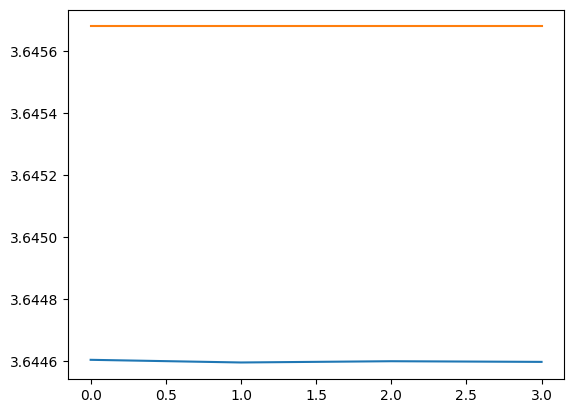

In [15]:
# 시각화
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])

bias가 0이 되는 이유는 L2 정규화를 적용했기 때문입니다. L2 정규화는 가중치에 제곱항을 추가하여 모델의 복잡도를 줄이고 오버피팅을 방지하는 기술입니다. 이는 모델이 데이터에 너무 맞춰져서 일반화되지 않는 것을 방지하고, 모델이 훈련 데이터뿐만 아니라 테스트 데이터에도 더 일반화되도록 도와줍니다.

가중치에 대한 L2 정규화 항은 다음과 같이 계산됩니다:
regularization_loss
=
𝜆
2
∑
𝑖
𝑤
𝑖
2
regularization_loss=
2
λ
​
 ∑
i
​
 w
i
2
​


여기서
𝜆
λ는 정규화 강도를 조절하는 하이퍼파라미터이고,
𝑤
𝑖
w
i
​
 는 각 가중치입니다.
𝑤
𝑖
2
w
i
2
​
  항이 모델의 가중치에 추가되므로, 이는 학습 중에 가중치가 작아지도록 유도합니다. 따라서 가중치가 0에 가까워지면서 편향(bias)도 0으로 수렴하게 됩니다.

# l1정규화

In [16]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Lambda

# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation='relu', kernel_regularizer=l1(1e-4))(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation='relu', kernel_regularizer=l1(1e-4))(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation='relu', kernel_regularizer=l1(1e-4))(mlp_layer)

# 출력층에 활성화 함수 적용 (Swish 함수)
def swish(x):
    return x * tf.keras.activations.sigmoid(x)

mlp_output = Dense(1, activation=swish)(mlp_layer)
mlp_output = Lambda(lambda x: x * 5)(mlp_output)  # 출력값을 0과 5 사이로 제한
mlp_output = Lambda(lambda x: tf.round(x * 2) / 2)(mlp_output)  # 평점 데이터가 0.5 단위로 되도록 반올림

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 1, 15)                15000     ['input_13[0][0]']            
                                                                                                  
 embedding_13 (Embedding)    (None, 1, 15)                24945     ['input_14[0][0]']            
                                                                                            

40123/40123 [==============================] - 109s 3ms/step - loss: 13.2863 - root_mean_squared_error: 3.6446 - val_loss: 13.2910 - val_root_mean_squared_error: 3.6457
Epoch 2/20
40123/40123 [==============================] - 108s 3ms/step - loss: 13.2861 - root_mean_squared_error: 3.6446 - val_loss: 13.2910 - val_root_mean_squared_error: 3.6457
Epoch 3/20
40123/40123 [==============================] - 108s 3ms/step - loss: 13.2861 - root_mean_squared_error: 3.6446 - val_loss: 13.2910 - val_root_mean_squared_error: 3.6457
Epoch 4/20
40123/40123 [==============================] - 107s 3ms/step - loss: 13.2861 - root_mean_squared_error: 3.6446 - val_loss: 13.2910 - val_root_mean_squared_error: 3.6457
Epoch 4: early stopping


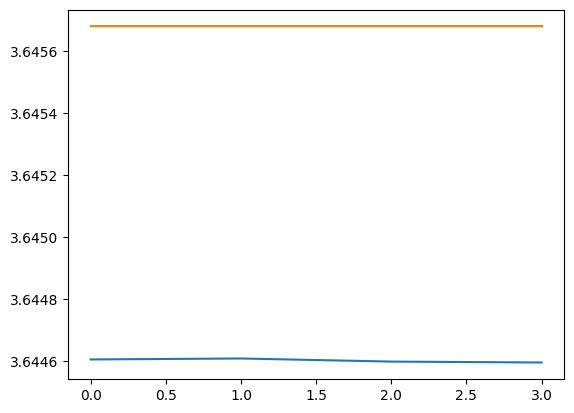

In [17]:
# 시각화
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])

# 학습률 줄여보기

In [21]:
from tensorflow.keras.layers import Activation

# Swish 함수 정의
def swish(x):
    return x * tf.sigmoid(x)

# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation=swish)(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation=swish)(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation=swish)(mlp_layer)

# 출력층
mlp_output = Dense(1, activation='sigmoid')(mlp_layer)

# 반올림 함수 정의
def round_to_nearest_half(x):
    return round(x * 2) / 2

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 1, 15)                15000     ['input_19[0][0]']            
                                                                                                  
 embedding_19 (Embedding)    (None, 1, 15)                24945     ['input_20[0][0]']            
                                                                                            

KeyboardInterrupt: 

# 데이터 표준화 및 스케일링 진행
StandartScaler 사용

In [32]:
from tensorflow.keras.layers import Activation

# Swish 함수 정의
def swish(x):
    return x * tf.sigmoid(x)

# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 데이터 표준화 및 스케일링
scaler = StandardScaler()
train_ratings_scaled = scaler.fit_transform(train_ratings.reshape(-1, 1))
test_ratings_scaled = scaler.transform(test_ratings.reshape(-1, 1))

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation=swish)(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation=swish)(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation=swish)(mlp_layer)

# 출력층
mlp_output = Dense(1, activation='swish')(mlp_layer)

# 반올림 함수 정의
def round_to_nearest_half(x):
    return round(x * 2) / 2

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_24 (Embedding)    (None, 1, 15)                15000     ['input_25[0][0]']            
                                                                                                  
 embedding_25 (Embedding)    (None, 1, 15)                24945     ['input_26[0][0]']            
                                                                                           

MinMax스케일러사용

In [34]:
from tensorflow.keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler

# Swish 함수 정의
def swish(x):
    return x * tf.sigmoid(x)

# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 데이터 표준화 및 스케일링
# MinMax 스케일러 사용

scaler = MinMaxScaler()
train_ratings_scaled = scaler.fit_transform(train_ratings.reshape(-1, 1))
test_ratings_scaled = scaler.transform(test_ratings.reshape(-1, 1))

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation=swish)(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation=swish)(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation=swish)(mlp_layer)

# 출력층
mlp_output = Dense(1, activation=swish)(mlp_layer)

# 반올림 함수 정의
def round_to_nearest_half(x):
    return round(x * 2) / 2

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_28 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_26 (Embedding)    (None, 1, 15)                15000     ['input_27[0][0]']            
                                                                                                  
 embedding_27 (Embedding)    (None, 1, 15)                24945     ['input_28[0][0]']            
                                                                                           

KeyboardInterrupt: 

# StandardScaler + 학습률 낮추기 + weight에 노이즈 추가

In [36]:
# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 데이터 표준화 및 스케일링
scaler = StandardScaler()
train_ratings_scaled = scaler.fit_transform(train_ratings.reshape(-1, 1))
test_ratings_scaled = scaler.transform(test_ratings.reshape(-1, 1))

# Swish 함수 정의
def swish(x):
    return x * tf.sigmoid(x)

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation=swish)(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation=swish)(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation=swish)(mlp_layer)

# 출력층
mlp_output = Dense(1, activation=swish)(mlp_layer)

# 반올림 함수 정의
def round_to_nearest_half(x):
    return round(x * 2) / 2

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 가중치에 노이즈 추가
noise_factor = 0.5  # 노이즈의 크기를 조절할 수 있는 하이퍼파라미터
for layer in model.layers:
    if isinstance(layer, Dense):  # Dense 레이어인 경우에만 노이즈 추가
        weights = layer.get_weights()
        noisy_weights = [w + noise_factor * np.random.normal(size=w.shape) for w in weights]
        layer.set_weights(noisy_weights)

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings_scaled,
    validation_data=([test_users, test_items], test_ratings_scaled),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_30 (Embedding)    (None, 1, 15)                15000     ['input_31[0][0]']            
                                                                                                  
 embedding_31 (Embedding)    (None, 1, 15)                24945     ['input_32[0][0]']            
                                                                                           

노이즈가 0.1이엇을땐 조기종료함
User
__________________________________________________________________________________________________
Epoch 1/20
40123/40123 [==============================] - 178s 4ms/step - loss: 1.0002 - root_mean_squared_error: 1.0001 - val_loss: 1.0041 - val_root_mean_squared_error: 1.0020
Epoch 2/20
40123/40123 [==============================] - 168s 4ms/step - loss: 0.9998 - root_mean_squared_error: 0.9999 - val_loss: 1.0046 - val_root_mean_squared_error: 1.0023
Epoch 3/20
40123/40123 [==============================] - 166s 4ms/step - loss: 0.9992 - root_mean_squared_error: 0.9996 - val_loss: 1.0043 - val_root_mean_squared_error: 1.0021
Epoch 4/20
40119/40123 [============================>.] - ETA: 0s - loss: 0.9990 - root_mean_squared_error: 0.9995Restoring model weights from the end of the best epoch: 1.
40123/40123 [==============================] - 169s 4ms/step - loss: 0.9990 - root_mean_squared_error: 0.9995 - val_loss: 1.0055 - val_root_mean_squared_error: 1.0027
Epoch 4: early stopping


# dropout 비율 높임.

In [37]:
# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 데이터 표준화 및 스케일링
scaler = StandardScaler()
train_ratings_scaled = scaler.fit_transform(train_ratings.reshape(-1, 1))
test_ratings_scaled = scaler.transform(test_ratings.reshape(-1, 1))

# Swish 함수 정의
def swish(x):
    return x * tf.sigmoid(x)

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation=swish)(concatenated)
mlp_layer = Dropout(0.5)(mlp_layer)
mlp_layer = Dense(64, activation=swish)(mlp_layer)
mlp_layer = Dropout(0.5)(mlp_layer)
mlp_layer = Dense(32, activation=swish)(mlp_layer)

# 출력층
mlp_output = Dense(1, activation=swish)(mlp_layer)

# 반올림 함수 정의
def round_to_nearest_half(x):
    return round(x * 2) / 2

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 가중치에 노이즈 추가
noise_factor = 0.5  # 노이즈의 크기를 조절할 수 있는 하이퍼파라미터
for layer in model.layers:
    if isinstance(layer, Dense):  # Dense 레이어인 경우에만 노이즈 추가
        weights = layer.get_weights()
        noisy_weights = [w + noise_factor * np.random.normal(size=w.shape) for w in weights]
        layer.set_weights(noisy_weights)

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings_scaled,
    validation_data=([test_users, test_items], test_ratings_scaled),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_34 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_32 (Embedding)    (None, 1, 15)                15000     ['input_33[0][0]']            
                                                                                                  
 embedding_33 (Embedding)    (None, 1, 15)                24945     ['input_34[0][0]']            
                                                                                           

KeyboardInterrupt: 

# gridSearch로 최적의 파라미터 찾기

In [49]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
# 모델 저장
model.save('model0426_2311.h5')

In [ ]:
# user_id==11의 평점이 0인데이터, 그린까 아직 평점을 매기지 않은 장소 구하기
unrated_places = pivot_table.loc[11].loc[pivot_table.loc[11] == 0].index
from tensorflow.keras.models import load_model

# 모델 불러오기
model = load_model('model0425_2200.h5')

df2 = df.copy()

# 모델 예측
predictions = model.predict([df2['user_id'], df2['place_id']])

# 예측 평점 출력
print(predictions)

# df2에 'predict_rating' 컬럼추가하기
df2['predict_rating'] = predictions

51969/51969 [==============================] - 100s 2ms/step


KeyboardInterrupt: 

In [ ]:
# user아이디가 11인 사람의 실제 평점과 예측평점
df2[df2['user_id'] == 11].sort_values(by='rating', ascending=False)

In [ ]:
# user아이디가 11인 사람의 예측평점구하기
df2[df2['user_id'] == 11][df2['rating']== 0].sort_values(by='predict_rating', ascending=False).head(10)

In [ ]:
df.info()